# Customer feedback and satisfaction

Data set downloaded from [Kaggle](https://www.kaggle.com/datasets/jahnavipaliwal/customer-feedback-and-satisfaction/data).

### Overview 

The _Customer Feedback and Satisfaction Dataset_ is a synthetic dataset designed to analyze and predict customer satisfaction based on various demographic and behavioral factors. It contains data for 38,444 customers, capturing their feedback on products and services in a structured format. This dataset is particularly useful for data scientists and machine learning practitioners looking to explore customer satisfaction metrics and develop predictive models for practice.

### Use cases

This dataset can be utilized for various analytical tasks, including:

- **Predictive Modeling**: Building regression models to predict customer satisfaction based on demographic and behavioral features.
- **Market Research**: Analyzing how different factors (age, income, product quality) affect customer satisfaction and feedback.
- **Customer Segmentation**: Identifying customer segments based on loyalty and satisfaction scores to tailor marketing strategies. 
- **Data Visualization**: Creating visualizations to explore trends and relationships among different features.

## Our predictive modeling

##### Package versions, important for reproducibility

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt # for convenience
import sklearn
import shap
import xgboost

shap.initjs() # so that all plots appear in the Jupyter notebook 

print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("sklearn version:", sklearn.__version__)
print("matplotlib version:", matplotlib.__version__)
print("shap version:", shap.__version__)
print("xgboost version:", xgboost.__version__)

pandas version: 1.5.3
seaborn version: 0.12.2
numpy version: 1.23.5
sklearn version: 1.2.1
matplotlib version: 3.7.0
shap version: 0.46.0
xgboost version: 2.1.2


In [2]:
df = pd.read_csv(filepath_or_buffer="C:\\Users\\popov\\Downloads\\customer-feedback\\customer_feedback_satisfaction.csv")

###### 1.1  How many rows there are, how many columns? What are the types of the columns?

In [3]:
df.shape

(38444, 11)

In [4]:
df.head()

,CustomerID,Age,Gender,Country,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,SatisfactionScore
0,1,56,Male,UK,83094,5,8,5,Low,Bronze,100.0
1,2,69,Male,UK,86860,10,2,8,Medium,Gold,100.0
2,3,46,Female,USA,60173,8,10,18,Medium,Silver,100.0
3,4,32,Female,UK,73884,7,10,16,Low,Gold,100.0
4,5,60,Male,UK,97546,6,4,13,Low,Bronze,82.0


In [5]:
df.dtypes

CustomerID             int64
Age                    int64
Gender                object
Country               object
Income                 int64
ProductQuality         int64
ServiceQuality         int64
PurchaseFrequency      int64
FeedbackScore         object
LoyaltyLevel          object
SatisfactionScore    float64
dtype: object

###### 1.2 What's the target variable? What's the distribution of the data across different target values? Is there any unusual finding there?

In [6]:
target_variable = "SatisfactionScore"

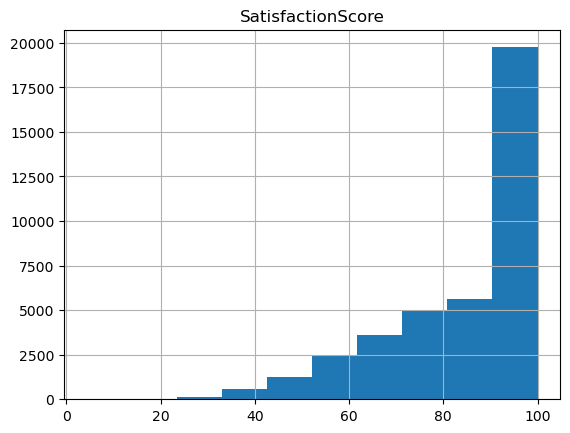

In [7]:
# univariate plot of a continuous variable
_ = df.hist(column=target_variable)

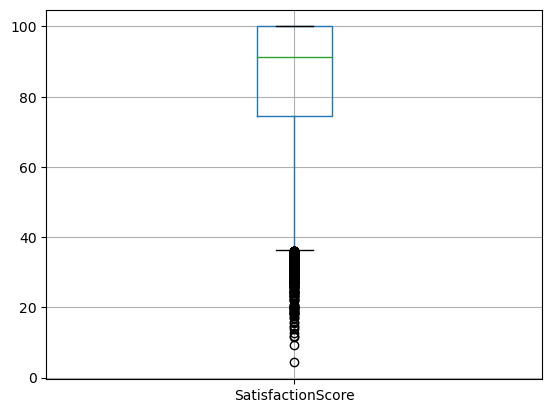

In [8]:
_ = df.boxplot(column=target_variable)

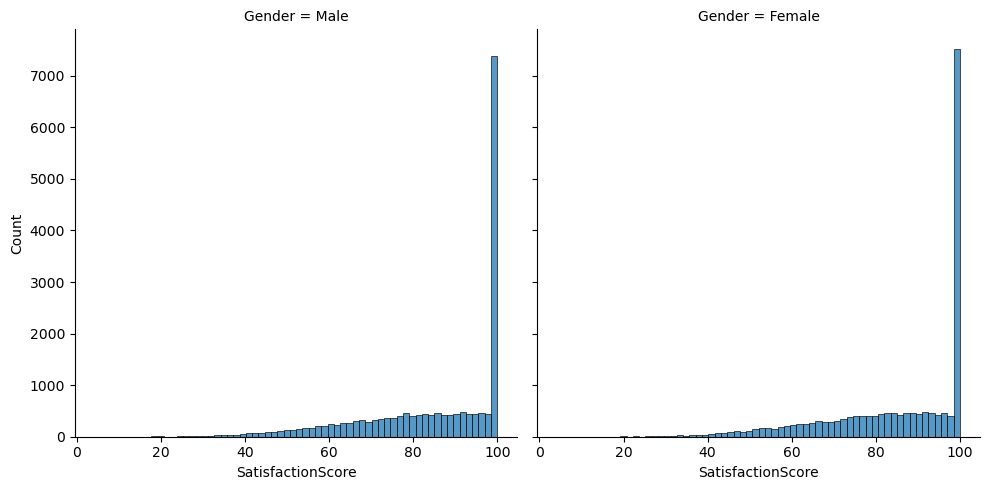

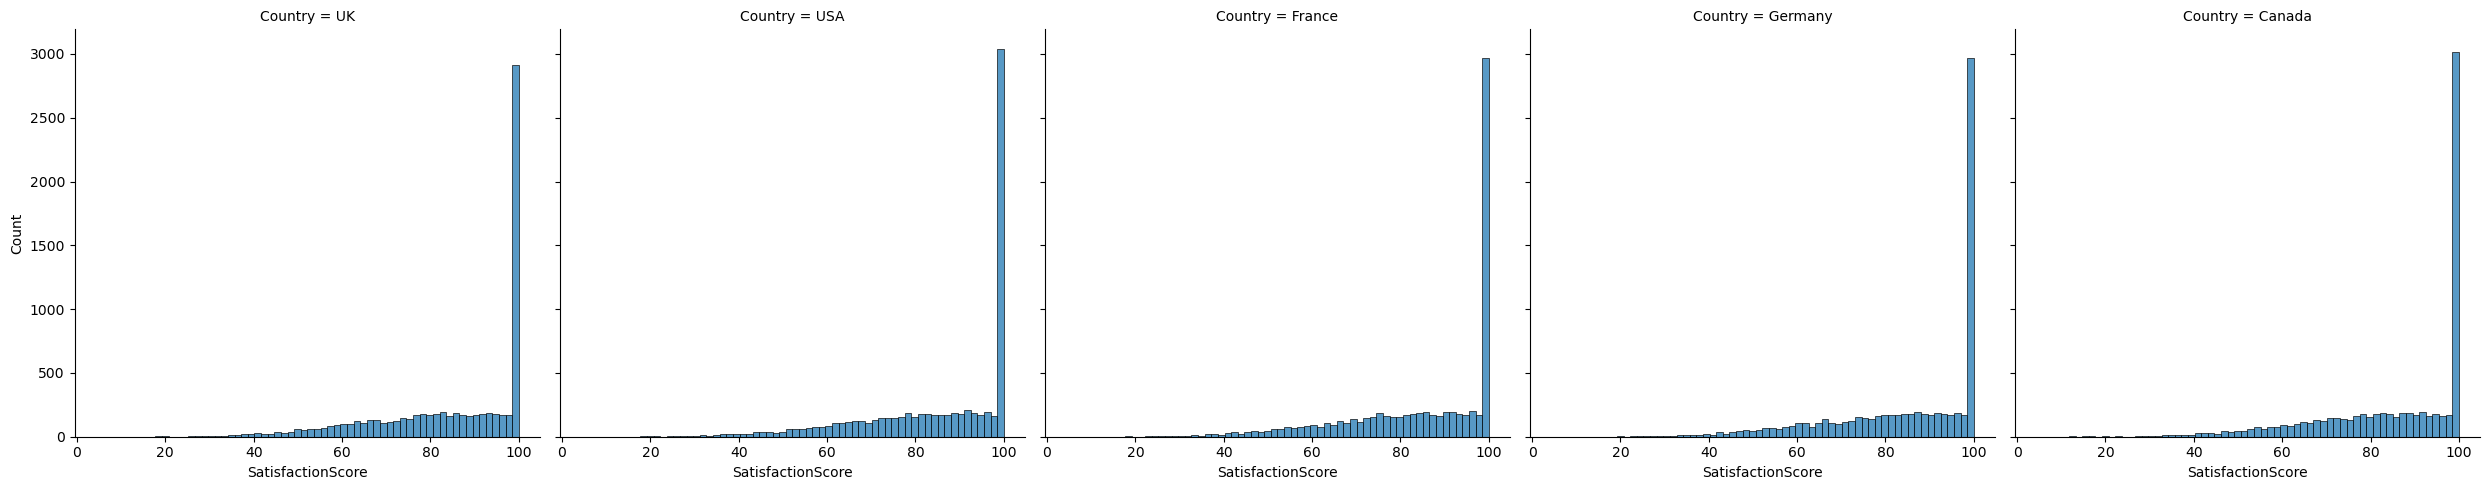

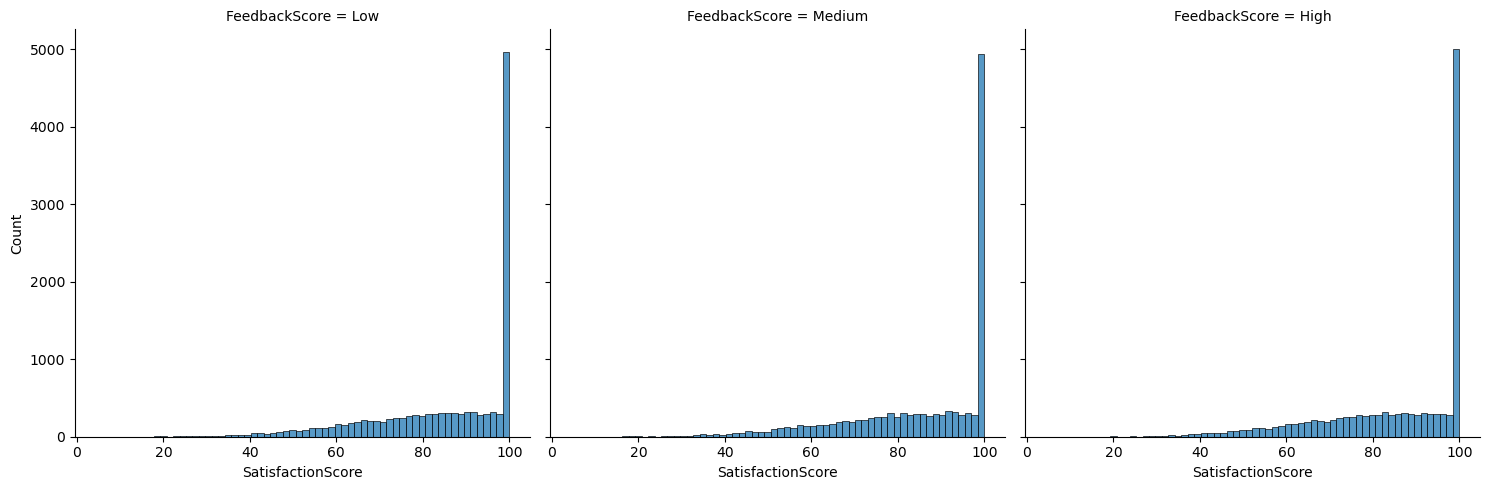

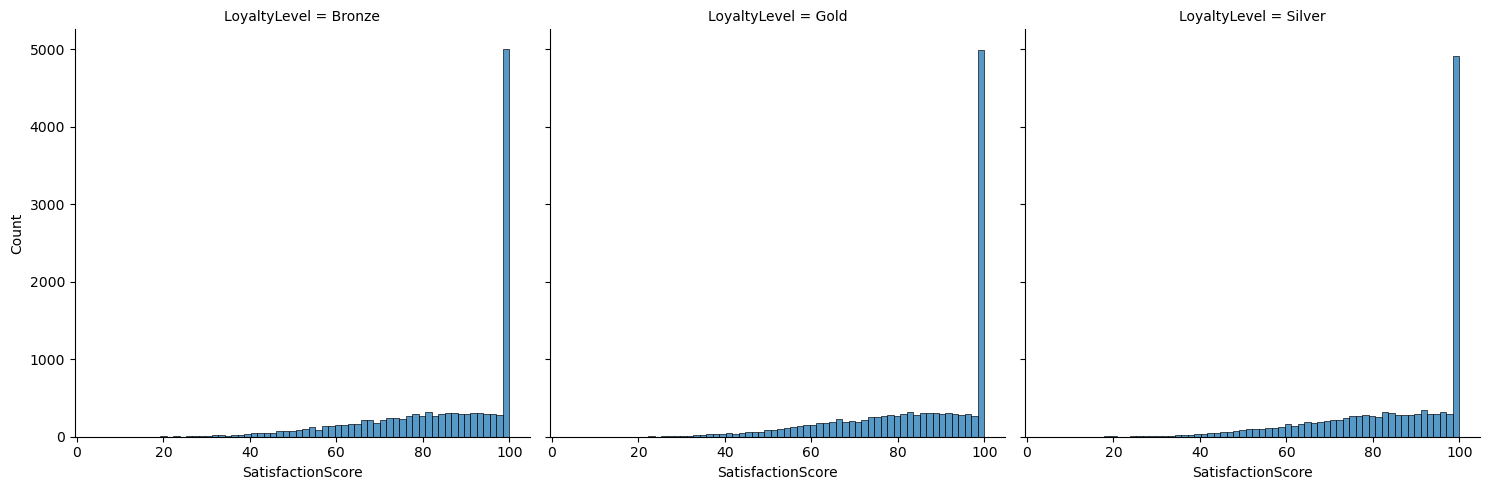

In [9]:
# univariate distribution plot conditioned on a categorical column
for column in ["Gender", "Country", "FeedbackScore", "LoyaltyLevel"]:
    _ = sns.displot(data=df, x=target_variable, col=column)

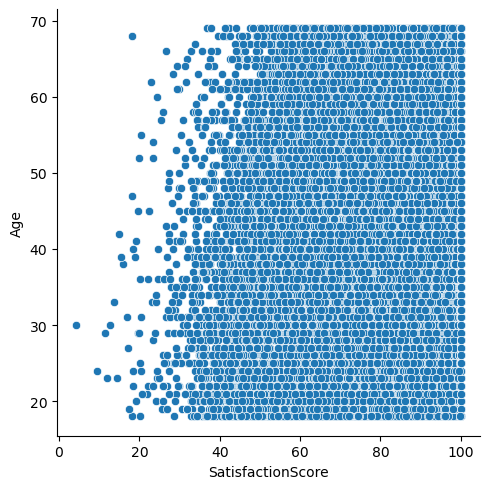

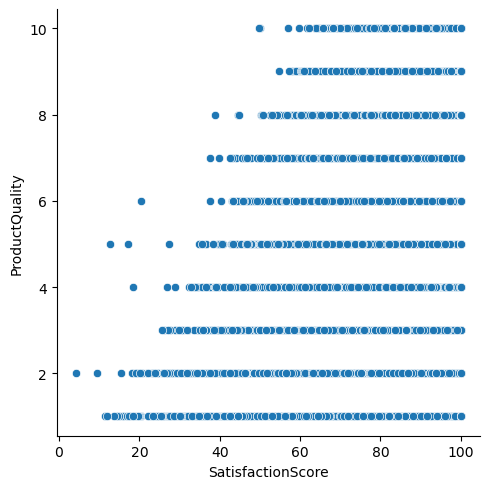

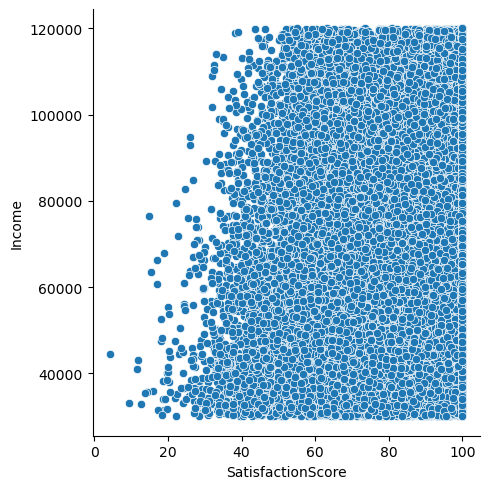

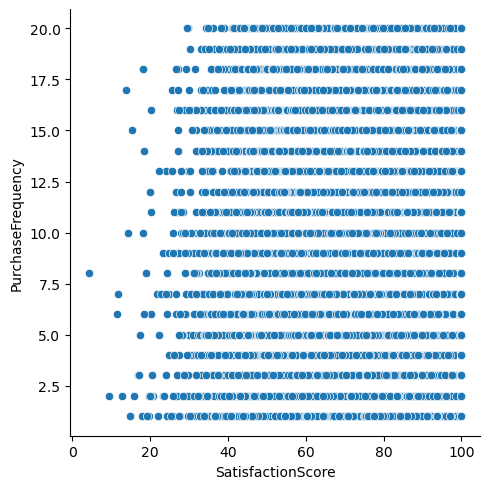

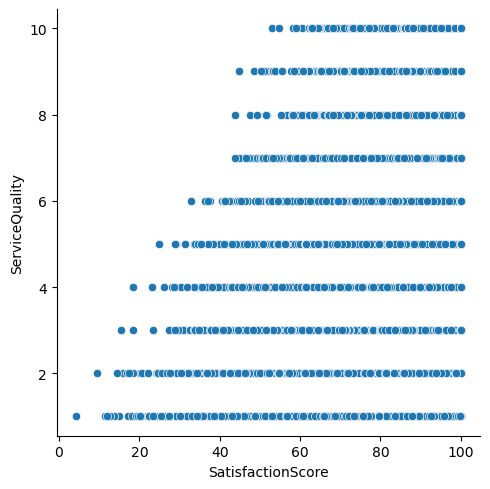

In [10]:
# scatter plots of the target variable in relationship with the input continuous variables
for column in ["Age", "ProductQuality", "Income", "PurchaseFrequency", "ServiceQuality"]:
    _ = sns.relplot(data=df, x=target_variable, y=column)

###### 1.3 Are there any missing values? Inconsistency across some dimension?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         38444 non-null  int64  
 1   Age                38444 non-null  int64  
 2   Gender             38444 non-null  object 
 3   Country            38444 non-null  object 
 4   Income             38444 non-null  int64  
 5   ProductQuality     38444 non-null  int64  
 6   ServiceQuality     38444 non-null  int64  
 7   PurchaseFrequency  38444 non-null  int64  
 8   FeedbackScore      38444 non-null  object 
 9   LoyaltyLevel       38444 non-null  object 
 10  SatisfactionScore  38444 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 3.2+ MB


In [12]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,38444.0,NaN,NaN,NaN,19222.5,11097.971211,1.0,9611.75,19222.5,28833.25,38444.0
Age,38444.0,NaN,NaN,NaN,43.496853,14.972748,18.0,31.0,43.0,56.0,69.0
Gender,38444,2,Female,19294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,38444,5,USA,7762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,38444.0,NaN,NaN,NaN,75076.619238,25975.752966,30001.0,52624.5,75236.0,97606.75,119999.0
ProductQuality,38444.0,NaN,NaN,NaN,5.494746,2.873192,1.0,3.0,5.0,8.0,10.0
ServiceQuality,38444.0,NaN,NaN,NaN,5.492769,2.875812,1.0,3.0,5.0,8.0,10.0
PurchaseFrequency,38444.0,NaN,NaN,NaN,10.453881,5.765621,1.0,5.0,10.0,15.0,20.0
FeedbackScore,38444,3,High,12918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoyaltyLevel,38444,3,Gold,12912,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Data wrangling: one-hot encoding, data split

In [13]:
df = pd.get_dummies(data=df,
                   prefix=["Gender_", "Country_", "FeedbackScore_", "LoyaltyLevel_"],
                   columns=["Gender", "Country", "FeedbackScore", "LoyaltyLevel"])

In [14]:
df.head().T

,0,1,2,3,4
CustomerID,1.0,2.0,3.0,4.0,5.0
Age,56.0,69.0,46.0,32.0,60.0
Income,83094.0,86860.0,60173.0,73884.0,97546.0
ProductQuality,5.0,10.0,8.0,7.0,6.0
ServiceQuality,8.0,2.0,10.0,10.0,4.0
PurchaseFrequency,5.0,8.0,18.0,16.0,13.0
SatisfactionScore,100.0,100.0,100.0,100.0,82.0
Gender__Female,0.0,0.0,1.0,1.0,0.0
Gender__Male,1.0,1.0,0.0,0.0,1.0
Country__Canada,0.0,0.0,0.0,0.0,0.0


In [15]:
df.dtypes

CustomerID                 int64
Age                        int64
Income                     int64
ProductQuality             int64
ServiceQuality             int64
PurchaseFrequency          int64
SatisfactionScore        float64
Gender__Female             uint8
Gender__Male               uint8
Country__Canada            uint8
Country__France            uint8
Country__Germany           uint8
Country__UK                uint8
Country__USA               uint8
FeedbackScore__High        uint8
FeedbackScore__Low         uint8
FeedbackScore__Medium      uint8
LoyaltyLevel__Bronze       uint8
LoyaltyLevel__Gold         uint8
LoyaltyLevel__Silver       uint8
dtype: object

In [16]:
# the customer ID, and the target column
ignore_columns = ["CustomerID", target_variable]

# everything else is an input feature
input_columns = [x for x in df.columns if x not in ignore_columns]

In [17]:
input_columns

['Age',
 'Income',
 'ProductQuality',
 'ServiceQuality',
 'PurchaseFrequency',
 'Gender__Female',
 'Gender__Male',
 'Country__Canada',
 'Country__France',
 'Country__Germany',
 'Country__UK',
 'Country__USA',
 'FeedbackScore__High',
 'FeedbackScore__Low',
 'FeedbackScore__Medium',
 'LoyaltyLevel__Bronze',
 'LoyaltyLevel__Gold',
 'LoyaltyLevel__Silver']

In [18]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df[input_columns], 
                                                                           df[target_variable], 
                                                                           test_size=0.2, 
                                                                           random_state=42)

###### Model training and evaluation

In [19]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [20]:
# more info about other parameters, and tuning them at: https://xgboost.readthedocs.io/en/stable/parameter.html
params = {
    "objective": "reg:squarederror",
    "base_score": np.mean(y_train),
    "eval_metric": "rmse"
}
model = xgboost.train(
    params=params, # dictonary of algorithm-specific parameters
    dtrain=d_train, # training data (careful, it's XGBoost specific data type - DMatrix)
    num_boost_round=5000, # how many estimators (trees) should there be
    evals=[(d_train, "train"), (d_test, "test")], # evaluation set - it's better if it's validation, not testing...
    verbose_eval=5, # how often should it print the progress
    early_stopping_rounds=5, # early stopping rounds - after how many iterations should the training stop if there's no improvement
)

[0]	train-rmse:13.45339	test-rmse:13.31676
[5]	train-rmse:8.08064	test-rmse:8.26505
[10]	train-rmse:7.50764	test-rmse:7.83250
[15]	train-rmse:7.37187	test-rmse:7.78564
[20]	train-rmse:7.27977	test-rmse:7.79088
[22]	train-rmse:7.24737	test-rmse:7.79547


In [21]:
y_pred = model.predict(d_test)

In [26]:
y_pred

array([77.95536 , 98.952484, 99.441216, ..., 92.441605, 95.521904,
       70.64352 ], dtype=float32)

In [28]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)

rmse, r2

(7.795466863507018, 0.7831180073913782)

###### Explainability

In [23]:
explainer = shap.Explainer(model)

In [24]:
shap_values = explainer(d_test)

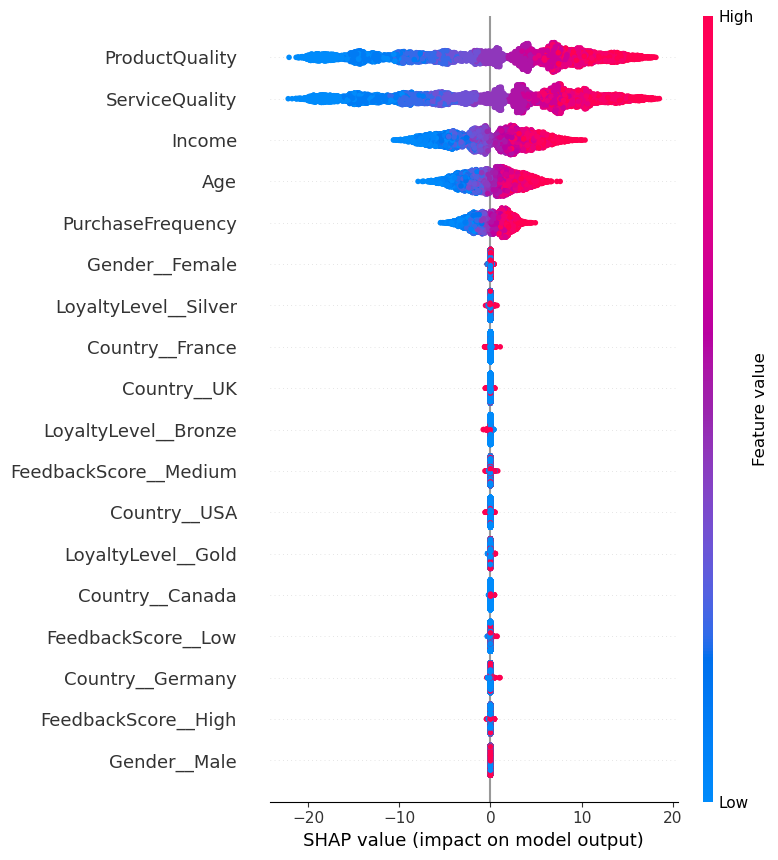

In [25]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

###### Save model to disk, in the appropriate format

### Conclusion

The _Customer Feedback and Satisfaction Dataset_ is a valuable resource for anyone interested in understanding customer behavior and enhancing business strategies through data-driven insights. Its structured relationships and varied features make it suitable for a wide range of data analysis and machine learning applications.